# Лабораторная работа 4. Кластеризация

## 1. Введение

**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Оценить информационную значимость признаков. Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

## 2. Описание датасета

В лабораторной работе используется датасет Customer Dataset, загруженный с платформы Kaggle. Набор данных содержит информацию о клиентах с тремя ключевыми характеристиками: возраст (Age), годовой доход (Annual Income) и оценка расходов (Spending Score). Эти атрибуты позволяют проводить анализ поведения клиентов и выявлять естественные группы для их последующей сегментации.

### Загрузка данных

Для начала загрузим датасет и выведем первые пять строчек:

In [131]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

data = pd.read_csv('customer_dataset.csv')
data.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,26,31,35
1,24,28,45
2,26,26,46
3,29,33,41
4,24,35,48


### Дескриптивный анализ данных

Размерность:

In [132]:
data.shape

(150, 3)

Датасет содержит 150 наблюдений и 3 признака.

Тип данных:

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Age                     150 non-null    int64
 1   Annual Income (k$)      150 non-null    int64
 2   Spending Score (1-100)  150 non-null    int64
dtypes: int64(3)
memory usage: 3.6 KB


Все признаки имеют числовые значения (int64).

Далее проверим данные на наличие пропусков:

In [134]:
data.isna().sum()

Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Анализ показывает, что внутри набора данных отсутствуют пропущенные значения, поэтому дополнительная очистка данных не требуется. Все записи корректны и могут быть использованы для анализа и кластеризации.

Далее были рассчитаны основные статистические характеристики для каждого числового признака:

In [135]:
data.describe().round(2)

,Age,Annual Income (k$),Spending Score (1-100)
count,150.00,150.00,150.00
mean,39.41,53.83,52.53
std,13.01,22.67,22.53
min,19.00,16.00,19.00
25%,26.00,33.00,33.00
50%,40.00,50.50,49.00
75%,52.00,73.00,73.00
max,65.00,118.00,101.00


Данные включают три ключевых признака: возраст, годовой доход и индекс трат.

Возраст (Age) клиентов варьируется от 19 до 65 лет, при этом медиана составляет 40 лет, что указывает на преобладание клиентов среднего возраста; стандартное отклонение в 13 лет отражает умеренную неоднородность выборки.

Годовой доход (Annual Income) распределён шире - от 16 до 118 тыс. долларов, со средним значением 53,8 тыс. и высокой дисперсией (std 22,7), что предполагает наличие как низко-, так и высокодоходных групп.

Показатель трат (Spending Score) имеет аналогичное стандартное отклонение (22,5) и распределён от 19 до 101, что делает его достаточно информативным признаком: часть клиентов тратит мало, а часть - очень активно.

Межквартильные интервалы по доходу и тратам почти совпадают (33-73), что позволяет ожидать хорошо различимых сегментов по уровню дохода и потребительской активности.

### Анализ нормальности распределений и матрицы корреляций

Построим гистограммы распределений:

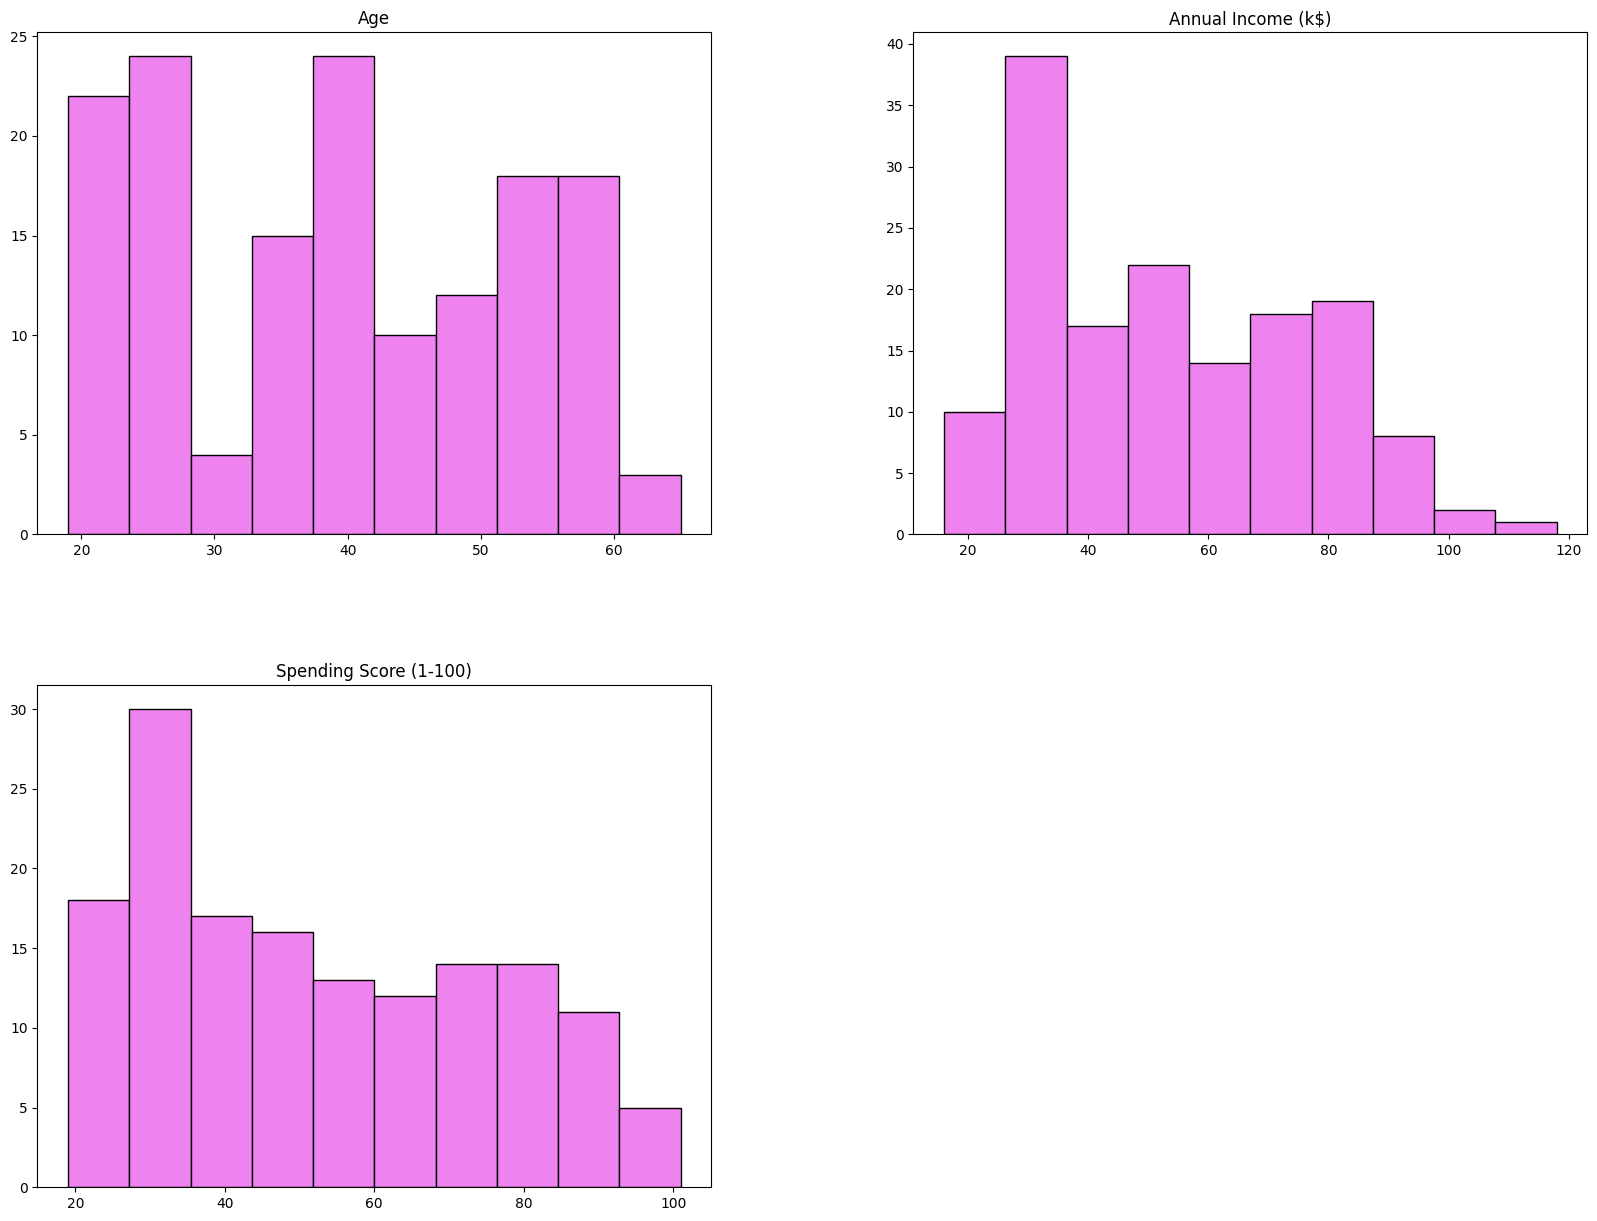

In [136]:
data.hist(figsize=(20,15), grid=False, edgecolor='black', color='violet')
plt.show()

По гистограммам видно, что ни один из признаков датасета не имеет нормального распределения.

Age демонстрирует умеренную неоднородность и едва заметную асимметрию, что отражает наличие нескольких возрастных групп.

Annual Income распределён неравномерно и имеет выраженную растянутость - заметны как низко-, так и высокодоходные клиенты, при этом распределение далеко от гауссовского.

Spending Score также несбалансирован: наблюдаются скопления клиентов с низкими и высокими значениями индекса трат, тогда как средние значения представлены менее выражено.

Таким образом, все три признака имеют отклонения от нормальности, что делает стандартизацию или нормализацию данных необходимым шагом перед кластеризацией.

Построим матрицу корреляций:

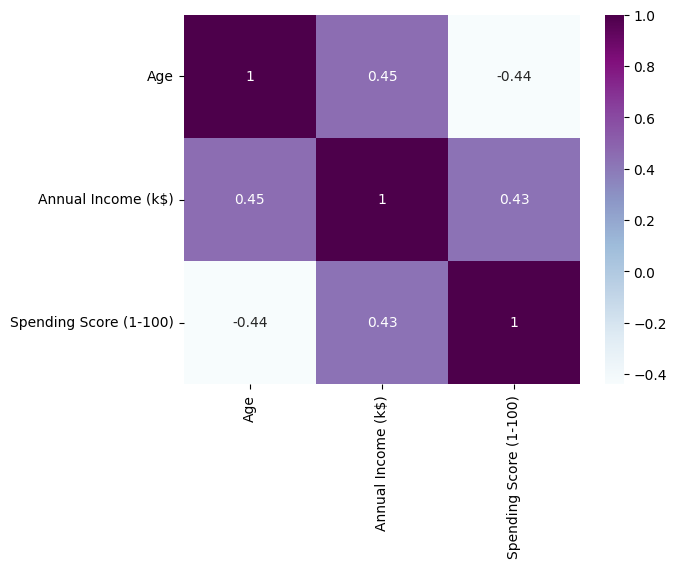

,Age,Annual Income (k$),Spending Score (1-100)
Age,1.00,0.39,-0.34
Annual Income (k$),0.39,1.00,0.59
Spending Score (1-100),-0.34,0.59,1.00


In [137]:
sns.heatmap(data.corr(method='spearman').round(2), annot=True, cmap='BuPu')
plt.show()
data.corr().round(2)

Корреляционный анализ показывает, что между признаками существует лишь умеренная связь.

Возраст слабо отрицательно коррелирует с индексом трат (-0.34), что означает: более молодые клиенты, как правило, тратят активнее, тогда как с возрастом склонность к высоким расходам снижается.

Между возрастом и доходом наблюдается умеренная положительная корреляция (0.39), указывающая на тенденцию роста дохода с увеличением возраста, хотя связь не является строгой.

Самая сильная связь в таблице - между доходом и показателем трат (0.59): клиенты с более высоким доходом чаще демонстрируют высокую покупательскую активность.

Однако ни один коэффициент не достигает уровня сильной корреляции, что говорит о том, что признаки дополняют друг друга и могут независимо влиять на процесс кластеризации.

### Анализ на выбросы

Проверим наличие выбросов при помощи ящика с усами:

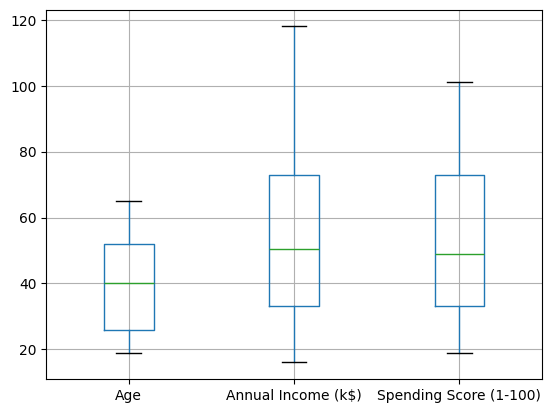

In [138]:
data.boxplot()
plt.show()

На ящике с усами выбросы отстуствуют.

## 3. Предобработка данных

### Стандартизация числовых признаков

После очистки данных и анализа статистических характеристик была проведена нормализация признаков с помощью метода StandardScaleraler.

Выбор StandardScaler обоснован тем, что признаки имеют разный масштаб и диапазон значений.

In [139]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(data)

data_scaled = pd.DataFrame(X_scaled, columns=data.columns)

### Матрица диаграмм рассеивания

Для визуальной оценки структуры данных была построена матрица диаграмм рассеяния:

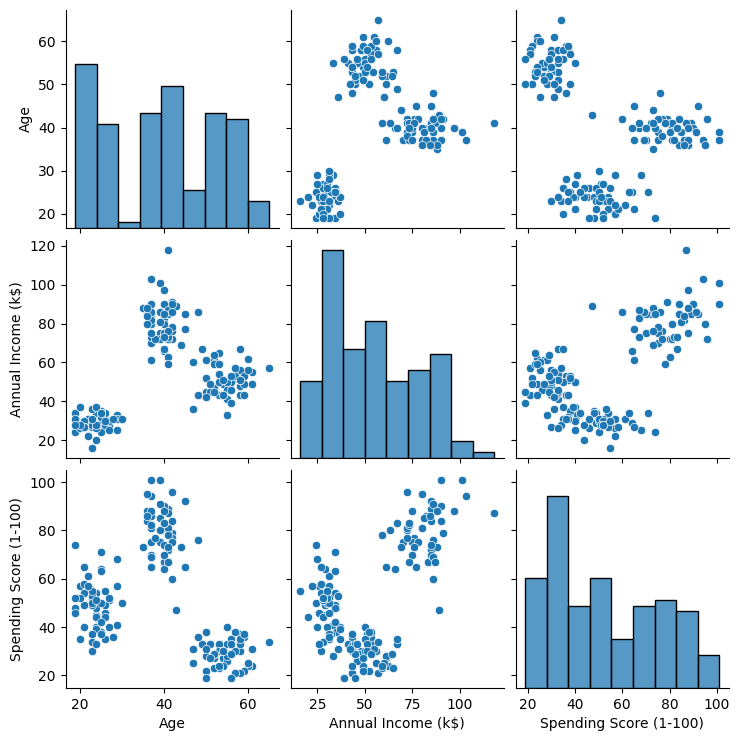

In [140]:
sns.pairplot(data)
plt.show()

Построенная матрица диаграмм рассеивания позволяет визуально оценить структуру данных и выявить потенциальные кластеры.

На графиках объекты распределены плотными группами, что позволяет выделить 2-3 кластера. При этом каждая группа имеет более компактную форму, чем вытянутую или ленточную, что облегчает применение алгоритмов вроде K-means (K-средних) или иерархической кластеризации и подтверждает наличие хорошо различимых сегментов в данных.

## 4. Ход работы

### 4.1. Иерархическая кластеризация

Для выбора оптимального числа кластеров k в иерархической кластеризации можно использовать силуэт-оценку или визуальный анализ дендрограммы.

#### Дендрограмма

Построим дендрограмму:

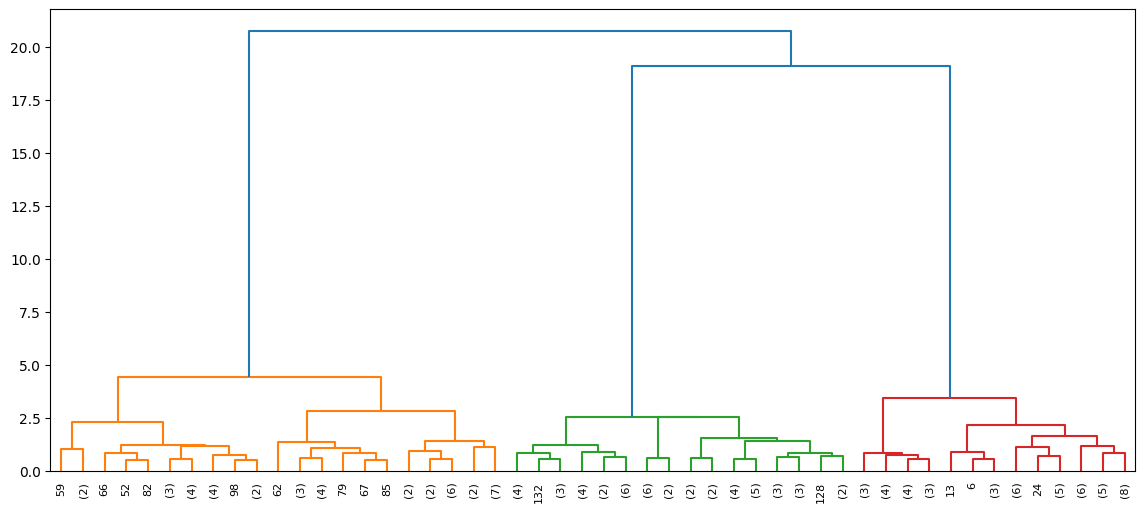

In [141]:
from scipy.cluster.hierarchy import dendrogram, linkage

plt.figure(figsize=(14, 6))
dendrogram(linkage(X_scaled, method='ward'), truncate_mode='lastp', p=50)
plt.grid(False)
plt.show()

На этой дендрограмме можно выделить 3 кластера: дальнейшее объединение происходит на значительно большем расстоянии.

#### График силуэта

Построим график силуэта:

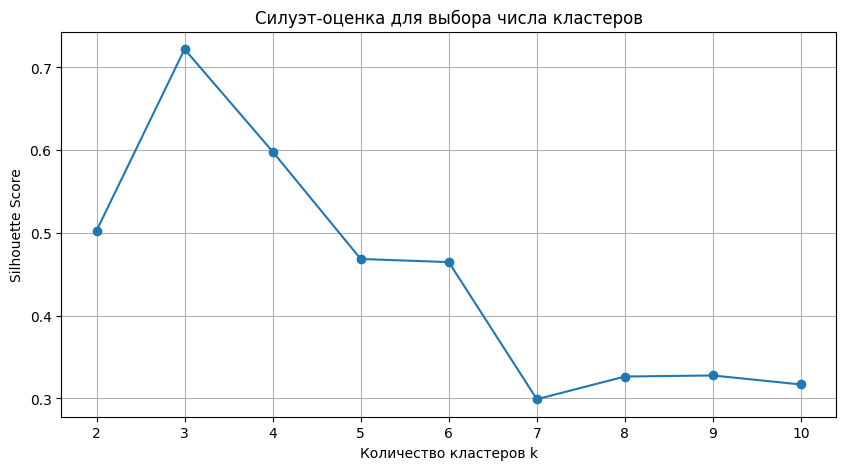

[0.5025483192580763,
 0.7216561319124224,
 0.5980339051622411,
 0.4684421218758494,
 0.4646462656093022,
 0.2991255110225368,
 0.32652812925570784,
 0.3277871331905197,
 0.31691550470707514]

In [142]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

K_range = range(2, 11) 
silhouette = []

for k in K_range:
    ac = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels = ac.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)

plt.figure(figsize=(10,5))
plt.plot(K_range, silhouette, marker='o')
plt.title("Силуэт-оценка для выбора числа кластеров")
plt.xlabel("Количество кластеров k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

silhouette

Силуэты показывают, что оптимальное число k = 3, поскольку именно при этом значении достигается максимальный показатель силуэта: 0,7216. Это существенно выше, чем при любых других k, что указывает на чёткое отделение групп и хорошую внутреннюю компактность кластеров.

При k = 2 силуэт-оценка также достаточно высокая (0,5025), но заметно ниже, чем при k = 3 - это значит, что разбиение на две группы избыточно упрощает структуру данных.

Начиная с k = 4 и далее наблюдается устойчивое снижение silhouette score, что говорит о размытости и ухудшении качества кластеров при большем числе групп.

Построим модель и выведем центры кластеров:

In [143]:
model_ac = AgglomerativeClustering(n_clusters=3)

y_ac = model_ac.fit_predict(X_scaled)

centroids_ac_array = data_scaled.groupby(y_ac).mean().to_numpy()
centroids_ac = pd.DataFrame(centroids_ac_array, columns=data.columns)

centroids_ac

,Age,Annual Income (k$),Spending Score (1-100)
0,0.027254,1.202741,1.191205
1,-1.200704,-1.073201,-0.156136
2,1.173450,-0.129540,-1.035069


### 4.2. Метод K-средних (K-means)

Для выбора оптимального числа кластеров k для метода K-средних (K-means) используется график силуэта и метод локтя.

#### График силуэта и метод локтя

Построим график силуэта и график метода локтя:

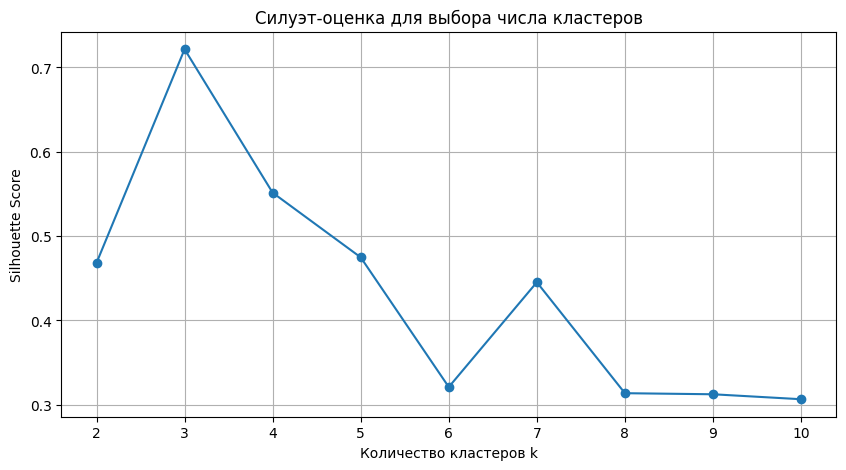

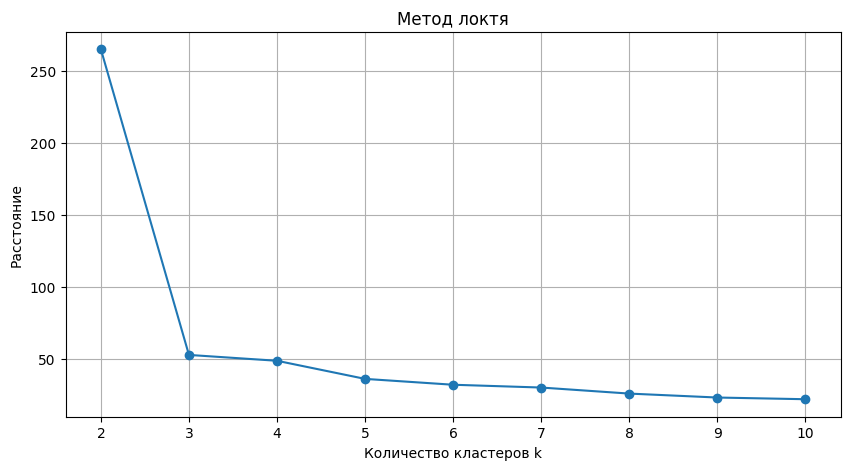

In [144]:
from sklearn.cluster import KMeans

K_range = range(2, 11) 
silhouette = []
inertias = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette.append(score)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K_range, silhouette, marker='o')
plt.title("Силуэт-оценка для выбора числа кластеров")
plt.xlabel("Количество кластеров k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(K_range, inertias, marker='o')
plt.title("Метод локтя")
plt.xlabel("Количество кластеров k")
plt.ylabel("Расстояние")
plt.grid(True)
plt.show()

На основании анализа графиков определения оптимального числа кластеров для алгоритма K-средних (K-means) установлено, что метод силуэта показывает наилучшее качество кластеризации при k = 3 (значение метрики около 0,72), что свидетельствует о чётком разделении объектов на группы. Метод локтя также демонстрирует выраженную точку перегиба при k = 3, что подтверждает выбор данного количества кластеров. Таким образом, оба метода согласованно указывают на оптимальность разбиения данных на три кластера.

Построим модель и выведем центры кластеров:

In [145]:
kmeans = KMeans(n_clusters=3)

y_kmeans = kmeans.fit_predict(X_scaled)

centroids_array = kmeans.cluster_centers_
centroids_kmeans = pd.DataFrame(centroids_array, columns=data.columns)

centroids_kmeans

,Age,Annual Income (k$),Spending Score (1-100)
0,0.027254,1.202741,1.191205
1,-1.200704,-1.073201,-0.156136
2,1.173450,-0.129540,-1.035069


### 4.3. Метрики качества кластеризации

#### 4.3.1. Внутренние метрики

##### Расстояние между кластерами

Рассчитаем средее межкластерное расстояние, измеряя, насколько далеко расположены центры полученных кластеров друг от друга для методов иерархической кластеризации (Agglomerative Clustering) и K-средних (K-means):

In [146]:
from scipy.spatial.distance import cdist, pdist


def distances(centroids):
    dist_matrix = cdist(centroids.values, centroids.values, metric='euclidean')
    pairwise_distances = pdist(centroids.values, metric='euclidean')
    mean_distance = pairwise_distances.mean()
    distances = pd.DataFrame(dist_matrix)
    
    return distances, mean_distance


_, mean_distance_ac = distances(centroids_ac)
_, mean_distance_kmeans = distances(centroids_kmeans)

print("Среднее межкластерное расстояние для Agglomerative Clustering:\n", mean_distance_ac)
print("Среднее межкластерное расстояние для K-means:\n", mean_distance_kmeans)

Среднее межкластерное расстояние для Agglomerative Clustering:
 2.818056398455049
Среднее межкластерное расстояние для K-means:
 2.818056398455049


Среднее межкластерное расстояние для Agglomerative Clustering и K-means оказалось одинаковым (2,818), что говорит о том, что обе модели формируют кластеры с практически одинаковой степенью разделённости. Это означает, что структура данных достаточно чёткая, и оба алгоритма приходят к сопоставимому разбиению пространства признаков.

##### Расстояние внутри кластеров

Рассчитаем среднее внутрикластерное расстояние, определяя, насколько плотно объекты группируются вокруг центроидов кластеров для методов кластеризации Agglomerative Clustering и K-means:

In [147]:
def intra_distances(centroids, y_pred):
    intra_distances = []

    for i in range(len(centroids)):
        cluster_points = X_scaled[y_pred == i]
        centroid = centroids.iloc[i].to_numpy().reshape(1, -1)  
        distances = cdist(cluster_points, centroid, metric='euclidean')
        mean_distance = distances.mean()
        intra_distances.append(mean_distance)

    return np.mean(intra_distances)


intra_ac = intra_distances(centroids_ac, y_ac)
intra_kmeans = intra_distances(centroids_kmeans, y_kmeans)

print("Среднее внутрикластерное расстояние для Agglomerative Clustering:\n", intra_ac)
print("Среднее внутрикластерное расстояние для K-means:\n", intra_kmeans)

Среднее внутрикластерное расстояние для Agglomerative Clustering:
 0.5276159187298712
Среднее внутрикластерное расстояние для K-means:
 0.5276159187298712


Среднее внутрикластерное расстояние для Agglomerative Clustering и K-means оказалось одинаковым (0,528), что указывает на одинаковую степень компактности кластеров, сформированных обоими алгоритмами. Поскольку внутрикластерное расстояние характеризует, насколько плотно расположены точки внутри своих кластеров, совпадение значений говорит о том, что обе методы находят практически идентичную внутреннюю структуру данных.

##### Компактность кластеров

Выполним расчёт компактности кластеров (WSS - within-cluster sum of squares), чтобы оценить степень однородности кластеров, сформированных методами Agglomerative Clustering и K-means:

In [148]:
def cluster_cohesion(X, labels):
    X = np.array(X)
    labels = np.array(labels)
    clusters = np.unique(labels)
    WSS = 0.0
    per_cluster_wss = {}

    for cluster in clusters:

        if (cluster == -1):
            continue
        
        points = X[labels == cluster]
        mean_cluster = points.mean(axis=0)
        wss = np.sum(np.linalg.norm(points - mean_cluster, axis=1)**2)
        per_cluster_wss[cluster] = float(wss)
        WSS += wss
    
    return float(WSS)

wss_ac = cluster_cohesion(X_scaled, y_ac)
wss_kmeans = cluster_cohesion(X_scaled, y_kmeans)

print('Kомпактность для Agglomerative Clustering:\n', wss_ac)
print('Kомпактность для K-means:\n', wss_kmeans)

Kомпактность для Agglomerative Clustering:
 52.53706882346998
Kомпактность для K-means:
 52.53706882346998


Компактность кластеров для Agglomerative Clustering и K-means получилась одинаковой (52,54), что ещё раз подтверждает: оба алгоритма выделяют практически одинаковую структуру в данных. Показатель компактности отражает суммарное расстояние объектов до центров своих кластеров (или до медианных точек для Agglomerative Clustering), поэтому совпадение значений означает, что плотность и внутренняя однородность кластеров у двух моделей полностью совпадает.

##### Коэффициент силуэта

Рассчитаем силуэтный коэффициент для кластеризаций Agglomerative Clustering и K-means, чтобы оценить качество разделения объектов на кластеры:

In [149]:
from sklearn.metrics import silhouette_score

ac_silhouette_score = silhouette_score(X_scaled, y_ac)
kmeans_silhouette_score = silhouette_score(X_scaled, y_kmeans)

print('Силуэт для Agglomerative Clustering:\n', ac_silhouette_score)
print('Силуэт для K-means:\n', kmeans_silhouette_score)

Силуэт для Agglomerative Clustering:
 0.7216561319124224
Силуэт для K-means:
 0.7216561319124224


Силуэтные оценки для Agglomerative Clustering и K-means совпали (0,722), что означает одинаковое качество разделения объектов на кластеры. Поскольку silhouette score измеряет отделённость и компактность кластеров, равные значения показывают, что оба алгоритма выделили схожую структуру данных.

##### Дополнительные метрики (Calinski-Harabasz и Davies-Bouldin)

Рассчитаем дополнительные метрики качества кластеризации - Calinski-Harabasz и Davies-Bouldin - для сравнения результатов Agglomerative Clustering и K-means:

In [150]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

ch_kmeans = calinski_harabasz_score(X_scaled, y_kmeans)
db_kmeans = davies_bouldin_score(X_scaled, y_kmeans)

ch_ac = calinski_harabasz_score(X_scaled, y_ac)
db_ac = davies_bouldin_score(X_scaled, y_ac)

print("Calinski-Harabasz для Agglomerative Clustering:\n", ch_ac)
print("Davies-Bouldin для Agglomerative Clustering:\n", db_ac)

print("\nCalinski-Harabasz для K-means:\n", ch_kmeans)
print("Davies-Bouldin для K-means:\n", db_kmeans)

Calinski-Harabasz для Agglomerative Clustering:
 556.0554879762217
Davies-Bouldin для Agglomerative Clustering:
 0.38616868035603913

Calinski-Harabasz для K-means:
 556.0554879762217
Davies-Bouldin для K-means:
 0.38616868035603913


Полученные значения метрик Calinski-Harabasz (556,05) и Davies-Bouldin (0,386) для Agglomerative Clustering и K-means полностью совпадают, что указывает на одинаковое качество кластеризации, достигнутое обоими методами. Высокий показатель Calinski-Harabasz свидетельствует о хорошей разделённости и компактности кластеров, а низкое значение метрики Davies-Bouldin отражает минимальное перекрытие между ними. Совпадение результатов подтверждает, что оба алгоритма выделили одну и ту же кластерную структуру данных.

##### Сравнительная характеристика метрик

Сформируем итоговую таблицу, в которой сведены внутренние метрики качества кластеризации для двух алгоритмов - иерархической кластеризации (Agglomerative Clustering) и K-средних (K-means). Таблица позволяет наглядно сравнить межкластерные расстояния, компактность кластеров и значения ключевых метрик качества:

In [151]:
metric = {
    "Внутренние метрики": [
        'Среднее межкластерное расстояние',
        'Среднее внутрикластерное расстояние',
        'Компактность',
        'Силуэт',
        'Calinski-Harabasz',
        'Davies–Bouldin',
    ],
    "Иерархическая кластеризация": [
        mean_distance_ac,
        intra_ac,
        wss_ac,
        ac_silhouette_score,
        ch_ac,
        db_ac
    ],
    "Метод K-средних (K-means)": [
        mean_distance_kmeans,
        intra_kmeans,
        wss_kmeans,
        kmeans_silhouette_score,
        ch_kmeans,
        db_kmeans
    ]
}

metric = pd.DataFrame(metric)

metric

,Внутренние метрики,Иерархическая кластеризация,Метод K-средних (K-means)
0,Среднее межкластерное расстояние,2.818056,2.818056
1,Среднее внутрикластерное расстояние,0.527616,0.527616
2,Компактность,52.537069,52.537069
3,Силуэт,0.721656,0.721656
4,Calinski-Harabasz,556.055488,556.055488
5,Davies–Bouldin,0.386169,0.386169


Итоговое сравнение внутренних метрик показывает, что результаты Agglomerative Clustering и K-means полностью совпадают по всем показателям. Средние межкластерные (2,818) и внутрикластерные расстояния (0,528) имеют одинаковые значения, что говорит о равной степени разделённости и плотности кластеров. Метрики компактности (52,537), силуэта (0,722), Calinski-Harabasz (556,05) и Davies-Bouldin (0,386) также идентичны, что подтверждает, что оба алгоритма выделили одну и ту же структуру данных. Это связано с тем, что кластеры в датасете хорошо разделены, отсутствуют выбросы, а признаки были предварительно стандартизированы.

#### 4.3.2. Внешние метрики

Поскольку в данных отсутствуют истинные классы, вычисление внешних метрик качества кластеризации (таких как индекс Rand, индекс Жаккара и другие) невозможно.

### 4.4. Влияние параметров

Исследуем влияние количества кластеров k на метод иерархической кластеризации.

Для выбора оптимального числа кластеров в иерархической кластеризации переберём значения k от 2 до 6, для каждого варианта построим визуализацию кластеров и рассчитаем внутренние метрики качества (средние меж- и внутрикластерные расстояния, компактность, силуэт, Calinski-Harabasz и Davies-Bouldin). Результаты сведём в итоговую таблицу.

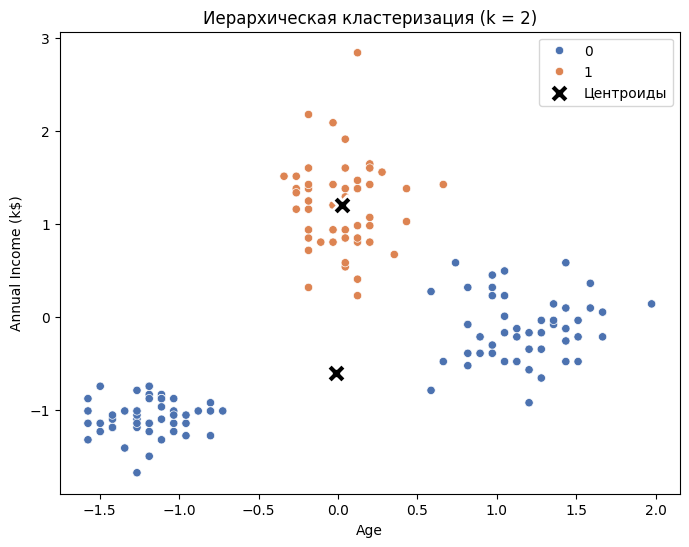

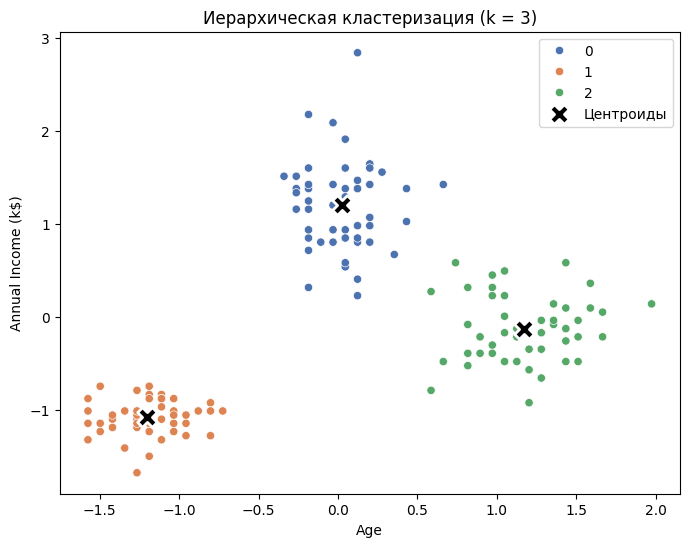

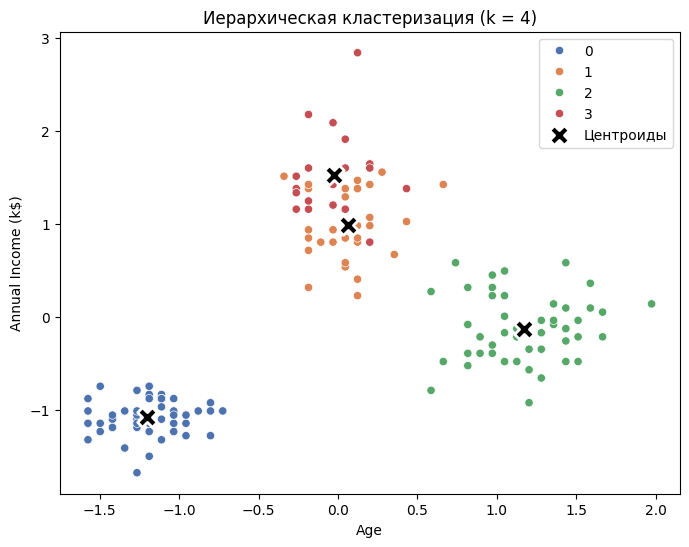

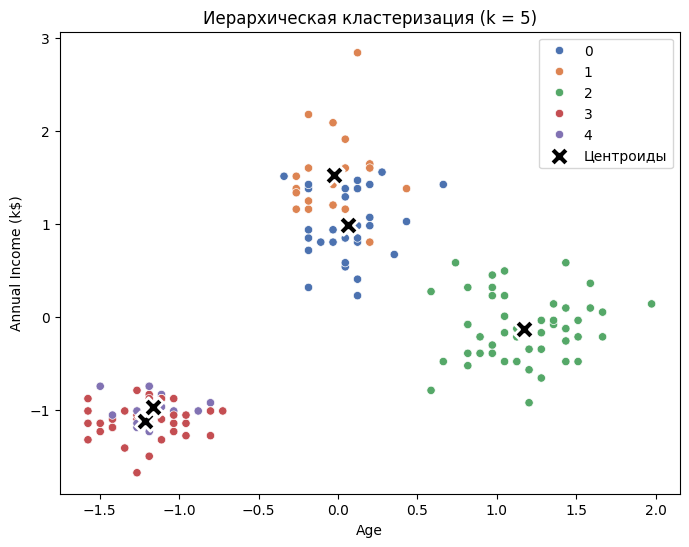

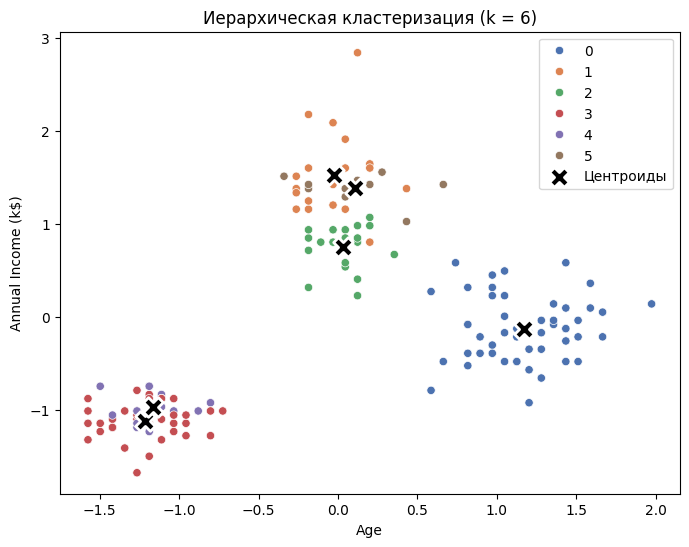

,k,Среднее межкластерное расстояние,Среднее внутрикластерное расстояние,Kомпактность,Силуэт,Calinski-Harabasz,Davies-Bouldin
0,2,2.539521,1.024713,235.027775,0.502548,135.370763,0.807013
1,3,2.818056,0.527616,52.537069,0.721656,556.055488,0.386169
2,4,2.576024,0.481967,42.758964,0.598034,463.506644,0.728976
3,5,2.511869,0.422802,36.863568,0.468442,406.260067,0.857168
4,6,2.342034,0.395894,32.919457,0.464646,364.888144,0.830307


In [152]:
K_range = range(2, 7) 
results = []

for k in K_range:
    ac = AgglomerativeClustering(n_clusters=k)
    y_pred = ac.fit_predict(X_scaled)

    centroids_a_array = data_scaled.groupby(y_pred).mean().to_numpy()
    centroids_a = pd.DataFrame(centroids_a_array, columns=data.columns)

    plt.figure(figsize=(8,6))
    sns.scatterplot(x=data_scaled['Age'], y=data_scaled['Annual Income (k$)'], hue=y_pred, palette='deep')
    plt.title(f'Иерархическая кластеризация (k = {k})')

    plt.scatter(centroids_a['Age'], centroids_a['Annual Income (k$)'], c='black', s=200, marker='X', label='Центроиды', edgecolor='white', linewidth=2)
    plt.legend()
    plt.show()

    wss = cluster_cohesion(X_scaled, y_pred)

    _, mean_distance_ac = distances(centroids_a)
    intra_ac = intra_distances(centroids_a, y_pred)
    wss_ac = cluster_cohesion(X_scaled, y_pred)
    silhouette = silhouette_score(X_scaled, y_pred)
    ch_ac = calinski_harabasz_score(X_scaled, y_pred)
    db_ac = davies_bouldin_score(X_scaled, y_pred)

    results.append({
            'k': k,
            'Среднее межкластерное расстояние': mean_distance_ac,
            'Среднее внутрикластерное расстояние': intra_ac,
            'Kомпактность': wss_ac,
            'Силуэт': silhouette,
            'Calinski-Harabasz': ch_ac,
            'Davies-Bouldin': db_ac
        })

results_df = pd.DataFrame(results)

results_df

Анализ влияния параметра k (количество кластеров) на качество модели показывает, что при k = 2 среднее межкластерное расстояние составляет 2,54, а среднее внутрикластерное расстояние - 1,02. Компактность кластеров высока (235,03), индекс Силуэта равен 0,50, Calinski-Harabasz - 135,37, а Davies-Bouldin - 0,81, что указывает на относительно слабое разделение и низкую плотность кластеров. При увеличении k до 3 наблюдается рост межкластерного расстояния до 2,82 и снижение внутрикластерного до 0,53, компактность резко падает до 52,54, индекс Силуэта достигает максимума 0,72, Calinski-Harabasz растёт до 556,06, а Davies-Bouldin снижается до 0,39, что говорит о значительном улучшении качества кластеризации.

Дальнейшее увеличение числа кластеров k до 4-6 сопровождается снижением межкластерных расстояний (2,58 → 2,34) и внутрикластерных (0,48 → 0,40), компактность постепенно уменьшается (42,76 → 32,92), индекс Силуэта падает (0,60 → 0,46), Calinski-Harabasz снижается (463,5 → 364,89), а Davies-Bouldin растёт (0,73 → 0,83). Это свидетельствует о том, что при больших k - кластеры становятся более мелкими и менее различимыми, то есть модель начинает дробить естественные группы.

На основе этих показателей оптимальным значением числа кластеров является k = 3.

### 4.5. Анализ распределения признаков по кластерам (диаграмма «ящик с усами»)

#### 4.5.1. Иерархическая кластеризация

Построим диаграммы «ящик с усами» для каждого признака по кластерам, чтобы визуально оценить распределение значений внутри групп и сравнить признаки между кластерами, полученными методом иерархической кластеризации:

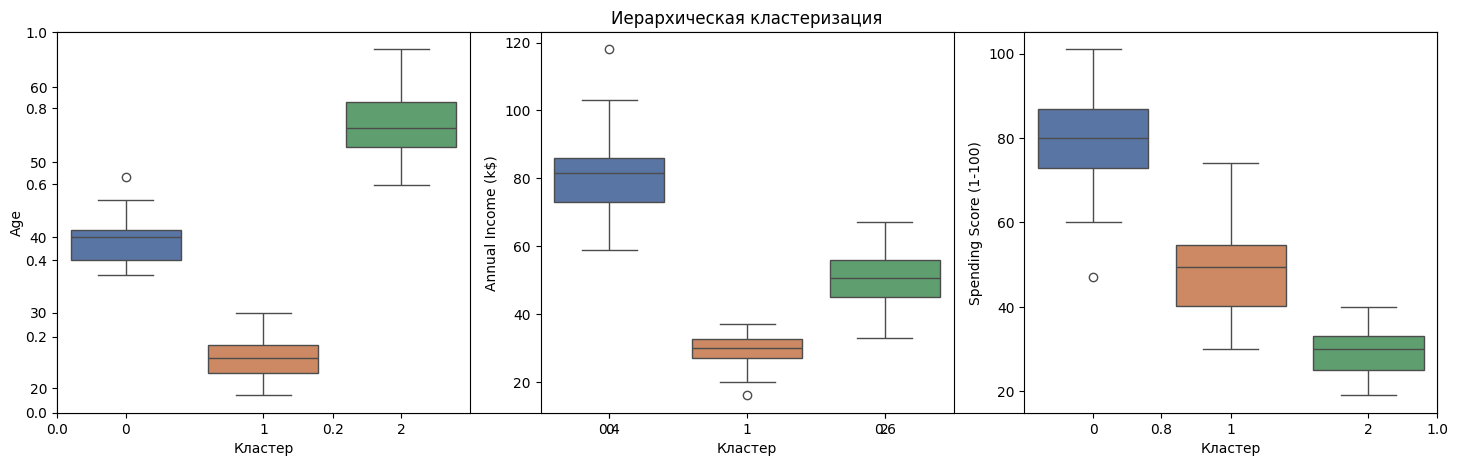

In [153]:
data_box = data.copy()
data_box['Cluster'] = y_ac

plt.figure(figsize=(15,5))
plt.title('Иерархическая кластеризация')

for i, col in enumerate(data.columns):
    plt.subplot(1, len(data.columns), i+1)
    sns.boxplot(x='Cluster', y=col, data=data_box, hue='Cluster', palette='deep', legend=False)
    plt.xlabel('Кластер')

plt.tight_layout()
plt.show()

Диаграммы «ящик с усами» показывают, что иерархическая кластеризация чётко разделила клиентов на три группы, каждая из которых имеет свои характерные значения возраста, дохода и уровня трат:

- Кластер 0 - клиенты со средним возрастом, высоким доходом и высокими тратами. Группа наиболее платёжеспособная.

- Кластер 1 - клиенты младшего возраста, с низким доходом и умеренными тратами.

- Кластер 2 - клиенты старшего возраста, со средним доходом и низкими тратами.

Такое разделение хорошо согласуется с визуальной структурой данных и подтверждает корректность выделенных кластеров.

#### 4.5.2. Метод K-средних (K-means)

Построим диаграммы «ящик с усами» для каждого признака по кластерам, полученным методом K-средних, чтобы визуально оценить распределение значений внутри групп и сравнить средние уровни признаков между кластерами:

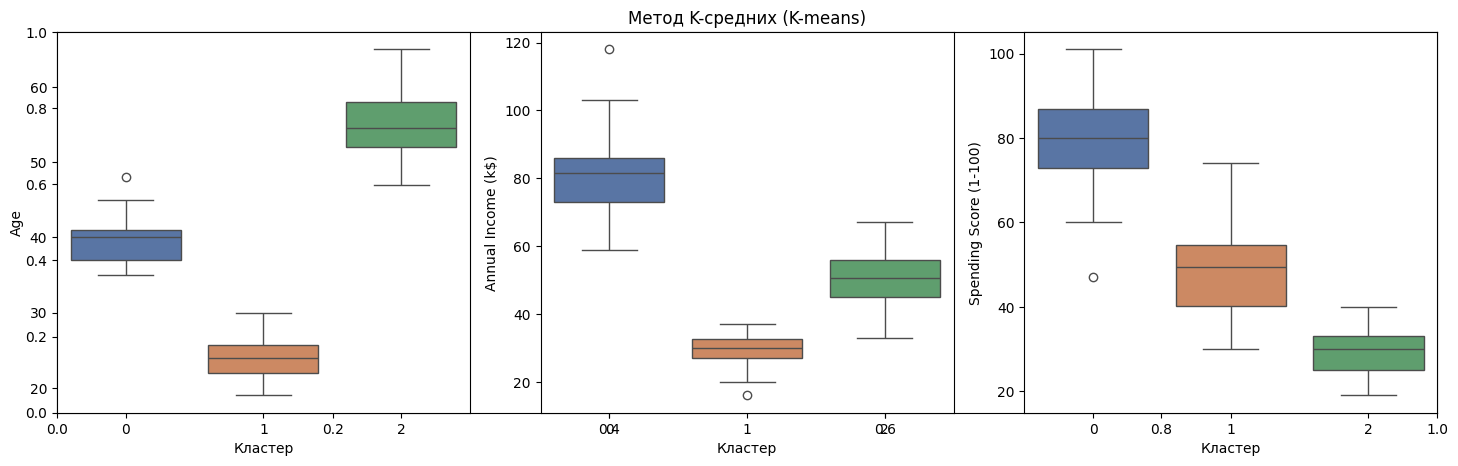

In [154]:
data_box = data.copy()
data_box['Cluster'] = y_kmeans

plt.figure(figsize=(15,5))
plt.title('Метод K-средних (K-means)')

for i, col in enumerate(data.columns):
    plt.subplot(1, len(data.columns), i+1)
    sns.boxplot(x='Cluster', y=col, data=data_box, hue='Cluster', palette='deep', legend=False)
    plt.xlabel('Кластер')

plt.tight_layout()
plt.show()

Диаграммы «ящик с усами» показывают, что метод K-средних также выделяет три отчётливые группы клиентов, отличающиеся по возрасту, уровню дохода и тратам:

- Кластер 0 - клиенты младшего возраста, с низким доходом и умеренными тратами.

- Кластер 1 - клиенты старшего возраста, со средним доходом и низким уровнем трат.

- Кластер 2 - клиенты среднего возраста, с высоким доходом и высокими тратами.

Распределения полностью согласуются с результатами иерархической кластеризации, что подтверждает устойчивость и чёткость кластерной структуры в данных.

Для обеих моделей - иерархической кластеризации и K-средних - видно, что кластеры хорошо различаются по средним значениям признаков Age, Annual Income (k$) и Spending Score (1-100). Средние значения признаков внутри кластеров различны, что позволяет наглядно отделять группы клиентов друг от друга. При этом в большинстве случаев средние значения кластеров совпадают между методами, что подтверждает согласованность выделенных групп и устойчивость структуры данных. Это говорит о том, что оба алгоритма выявляют схожие сегменты клиентов, несмотря на различие подходов к кластеризации.

### 4.6. Оценка значимости признаков

Оценим значимость признаков методом ANOVA (f-test) (однофакторный дисперсионный анализ), чтобы определить, какие признаки вносят наибольший вклад в формирование кластеров для метода иерархической кластеризации и метода K-средних (K-means):

In [155]:
from sklearn.feature_selection import f_classif

def anova(labels):
    F_values, p_values = f_classif(X_scaled, labels)

    return pd.DataFrame({
        'feature': data.columns,
        'F_value': F_values,
        'p_value': p_values
    }).sort_values(by='F_value', ascending=False)

print('Значимость признаков метода иерахической кластеризации:\n', anova(y_ac), '\n')
print('Значимость признаков метода K-средних (K-means):\n', anova(y_kmeans))

Значимость признаков метода иерахической кластеризации:
                   feature      F_value       p_value
0                     Age  1147.554157  1.981994e-90
1      Annual Income (k$)   499.415310  2.834477e-66
2  Spending Score (1-100)   380.871174  7.119143e-59 

Значимость признаков метода K-средних (K-means):
                   feature      F_value       p_value
0                     Age  1147.554157  1.981994e-90
1      Annual Income (k$)   499.415310  2.834477e-66
2  Spending Score (1-100)   380.871174  7.119143e-59


Анализ значимости признаков показал, что для обоих методов кластеризации - иерархического и K-средних (K-means) - наиболее влиятельным фактором при разделении клиентов является возраст (F = 1147, p ≈ 0), за ним следуют годовой доход (F = 499) и индекс трат (F = 381), при этом крайне малые p-value для всех признаков подтверждают их статистическую значимость; совпадение результатов обоих алгоритмов указывает на стабильную структуру данных, где возраст оказывает наибольшее влияние на формирование кластеров, а доход и индекс трат вносят умеренный вклад.

## 5. Визуализация результатов

Перед построением графиков сведём данные к двум главным компонентам с помощью PCA (метод главных компонент), чтобы визуально представить кластеры в 2D-пространстве. Затем отобразим результаты кластеризации для методов иерархической кластеризации (Agglomerative Clustering) и K-средних (K-means), включая положения центроидов.

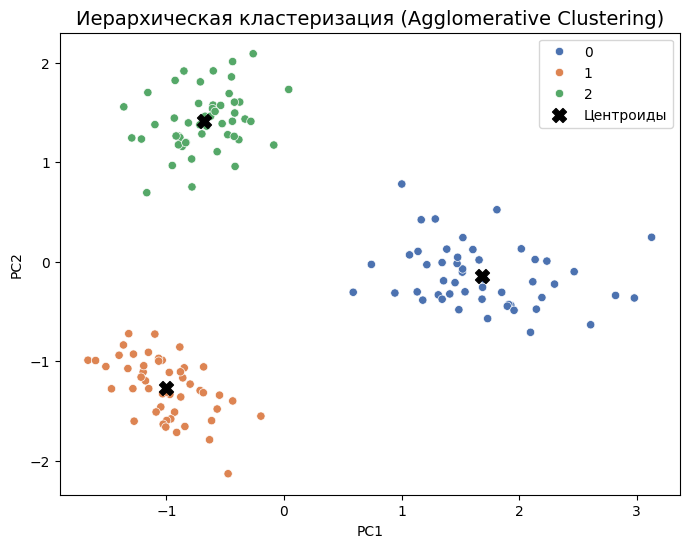

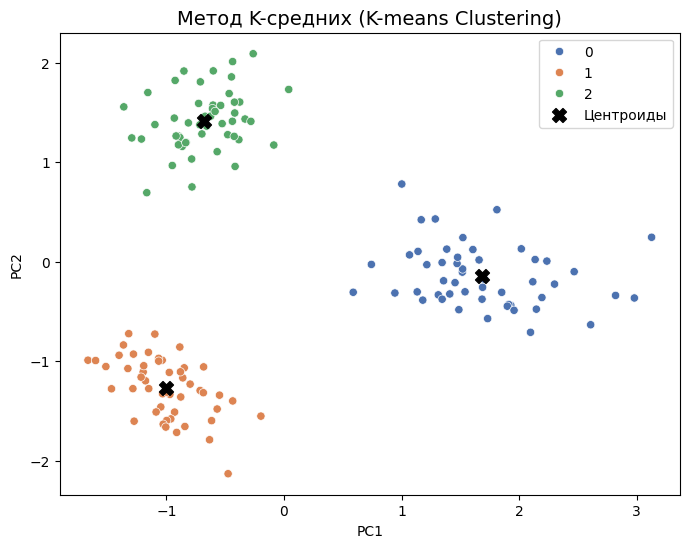

In [156]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

def plot_pca_scatter(X_pca, labels, title, centroids=None):
    plt.figure(figsize=(8,6))
    sns.scatterplot( x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='deep',legend='full')

    if centroids is not None:
        centroids_np = np.array(centroids)
        centroids_pca = pca.transform(centroids_np)
        plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],c='black', s=100, marker='X', label='Центроиды')

    plt.title(title, fontsize=14)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend()
    plt.show()

plot_pca_scatter(X_pca, y_ac, title='Иерархическая кластеризация (Agglomerative Clustering)', centroids=centroids_ac)
plot_pca_scatter(X_pca, y_kmeans, title='Метод K-средних (K-means Clustering)', centroids=centroids_kmeans)

Полученные визуализации позволяют наглядно сравнить структуру кластеров, сформированных двумя различными методами - иерархической кластеризации (Agglomerative Clustering) и K-средних (K-means). После снижения размерности при помощи PCA до двух компонент кластеры оказались хорошо разделимы в 2D-пространстве, что подтверждает результаты количественных метрик, рассчитанных ранее.

**Анализ визуализации иерархической кластеризации (Agglomerative Clustering):**

На первом графике показано распределение объектов после иерархической (агломеративной) кластеризации. Видно, что метод корректно выделяет три компактные группы:

- кластеры расположены достаточно далеко друг от друга;

- внутрикластерная плотность высокая;

- центры групп (вычисленные как средние координаты точек кластера) находятся близко к визуальным центрам выделенных областей.

Несмотря на то, что иерархический (агломеративный) метод не использует понятие центроидов в процессе обучения, их последующее вычисление позволяет оценить компактность каждого кластера и расстояние между группами. Можно заметить, что иерархический алгоритм формирует относительно симметричные кластеры и хорошо разделяет группы, что согласуется с высоким значением силуэта, полученным на предыдущем этапе.

**Анализ визуализации метода K-средних (K-means):**

На втором графике представлены результаты работы метода K-средних (K-means). Визуально кластеры также четко отделены, но в отличие от иерархической кластеризации:

- центроиды K-средних (черные метки X) расположены точно в геометрических центрах кластеров - это характерная особенность метода;

- форма и плотность кластеров не отличаются от результата иерархического алгоритма, что подтверждает стабильность структуры данных;

- разделение групп также выражено довольно отчётливо, хотя на границах кластеров возможно небольшое количество точек, которые могли быть отнесены к другому кластеру.

PCA-представление демонстрирует, что оба метода находят одинаковую структуру данных, что указывает на устойчивость кластеров и их хорошо выраженную природу.

**Сравнение двух методов по визуализации:**

Из графиков можно сделать следующие выводы:

1. Оба метода выявляют одинаковое количество кластеров и одинаковые группы наблюдений.

2. Форма кластеров близка к эллиптической, что хорошо подходит для метода K-средних (K-means).

3. Метод иерархической кластеризации (Agglomerative Clustering) немного сильнее «придерживается» плотных областей данных, что иногда делает его более устойчивым к выбросам.

4. Визуально границы кластеров совпадают, что подтверждает выводы из метрик качества: различия между методами отсутствуют.

Таким образом, визуальный анализ подтверждает корректность выбранных методов кластеризации, а также то, что данные действительно имеют выраженную кластерную структуру.

## 6. Заключение

В ходе выполнения работы были проведены все основные этапы анализа данных и кластеризации: выполнен предварительный анализ и масштабирование данных, исследовано оптимальное количество кластеров, реализованы два различных метода кластеризации - иерархическая кластеризация и K-средних, рассчитаны их метрики качества, а также выполнена визуализация результатов с использованием метода главных компонент PCA.

Обе реализованные модели продемонстрировали высокую согласованность результатов. Методы иерархической кластеризации и K-средних выделили одинаковое количество кластеров - три - и распределили объекты по группам идентичным образом. На двумерной проекции PCA видно, что точки формируют три компактные и хорошо отделимые группы. Независимо от выбранного алгоритма структура кластеров остаётся прежней:

- Метод K-средних стремится минимизировать внутрикластерные расстояния и помещает центроиды в геометрические центры групп;

- Метод иерархической (агломеративной) кластеризации последовательно объединяет объекты на основе расстояний, но итоговое разбиение полностью совпадает с результатами метода K-средних.

Такое совпадение результатов двух принципиально разных методов свидетельствует о том, что данные обладают устойчивой, хорошо выраженной естественной кластерной структурой, а полученные кластеры отражают реальные закономерности распределения объектов. Это подтверждается как визуально, так и количественно - значениями силуэта, внутрикластерных расстояний и расстояний между центрами кластеров.

Таким образом, можно заключить, что выбранные методы кластеризации являются применимыми и эффективными для данного набора данных. Они позволяют надёжно выявить три выраженных сегмента, которые могут быть использованы для последующей интерпретации, профилирования объектов и принятия аналитических решений.